In [ ]:
!pip install brminer
!pip install orange3
!pip install scikit-posthocs

     |████████████████████████████████| 26.5 MB 87 kB/s 
     |████████████████████████████████| 489 kB 50.1 MB/s 
     |████████████████████████████████| 2.4 MB 32.9 MB/s 
     |████████████████████████████████| 992 kB 60.5 MB/s 
     |████████████████████████████████| 149 kB 55.0 MB/s 
     |████████████████████████████████| 852 kB 58.9 MB/s 
     |████████████████████████████████| 8.3 MB 52.4 MB/s 
     |████████████████████████████████| 228 kB 54.0 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 47 kB 4.7 MB/s 
     |████████████████████████████████| 1.0 MB 72.5 MB/s 
     |████████████████████████████████| 58 kB 5.6 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 78 kB 6.6 MB/s 
     |████████████████████████████████| 51 kB 6.4 MB/s 
     |████████████████████████████████| 59.9 MB 87 kB/s 
     |████████████████████████████████| 317 kB 51.6 MB/s 
     |██████████████████████

     |████████████████████████████████| 43 kB 1.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-posthocs: filename=scikit_posthocs-0.6.7-py3-none-any.whl size=37902 sha256=2e796989fbdf54eeb4b25eae8aa1036394796db27714887af5e8497cf0a81efe
  Stored in directory: /root/.cache/pip/wheels/b8/21/e6/f39794d4a6ee3d3cc5146ca80b5cd949452ad4a8fde9f6b9fc
Successfully built scikit-posthocs


## BRMiner Modification

In [ ]:
%%file /usr/local/lib/python3.7/dist-packages/brminer/__init__.py

import numpy as np
import math
import os
import random
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import pairwise_distances 
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class BRM(BaseEstimator):
    def __init__(self, classifier_count=100, bootstrap_sample_percent=100, use_bootstrap_sample_count=False, bootstrap_sample_count=0, use_past_even_queue=False, max_event_count=3, alpha=0.5, user_threshold=95, dissimilarity='euclidean'):
        self.classifier_count = classifier_count
        self.bootstrap_sample_percent = bootstrap_sample_percent
        self.use_bootstrap_sample_count = use_bootstrap_sample_count
        self.bootstrap_sample_count = bootstrap_sample_count
        self.use_past_even_queue = use_past_even_queue
        self.max_event_count = max_event_count
        self.alpha = alpha
        self.user_threshold = user_threshold
        self.dissimilarity = dissimilarity
        
    def _evaluate(self, current_similarity):
        if (current_similarity < 0):
            current_similarity = 0

        if (self.use_past_even_queue == False):
            return -1+2*current_similarity
        
        result_similarity = (self.alpha * self._similarity_sum / self.max_event_count + (1 - self.alpha) * current_similarity)
        if (result_similarity < 0):
            result_similarity = 0

        self._similarity_sum += current_similarity

        if (len(self._past_events) == self.max_event_count):
            self._similarity_sum -= self._past_events.pop(0)

        self._past_events.append(current_similarity)

        if (self._similarity_sum < 0):
            self._similarity_sum = 0

        return -1+2*result_similarity

    def score_samples(self, X):
        X_test = pd.DataFrame(X)
        X_test = pd.DataFrame(self._scaler.transform(X_test[X_test.columns]), index=X_test.index, columns=X_test.columns)  

        current_similarity = np.average([np.exp(-np.power(np.amin(pairwise_distances(X_test, self._centers[i], metric=self.dissimilarity), axis=1)/self._max_dissimilarity, 2)/(self._sd[i])) for i in range(len(self._centers))], axis=0)
        return list(map(self._evaluate, current_similarity))
        

    def predict(self, X):
        if (len(X.shape) < 2):
            raise ValueError('Reshape your data')

        if (X.shape[1] != self.n_features_in_):
            raise ValueError('Reshape your data')

        if not self._is_threshold_Computed:            
            x_pred_classif = self.score_samples(self._X_train)            
            x_pred_classif.sort()
            self._inner_threshold = x_pred_classif[(100-self.user_threshold)*len(x_pred_classif)//100]
            self._is_threshold_Computed = True

        y_pred_classif = self.score_samples(X)
        return [-1 if s <= self._inner_threshold else 1 for s in y_pred_classif]
        

    def fit(self, X, y):
        # Check that X and y have correct shape
        X_train, y_train = check_X_y(X, y)
        self._similarity_sum = 0
        self._is_threshold_Computed = False

        self.n_features_in_ = X_train.shape[1]

        if self.n_features_in_ < 1:
            raise ValueError('Unable to instantiate the train dataset - Empty vector')     
        
        self._scaler = MinMaxScaler()
        X_train = pd.DataFrame(X_train)
        X_train = pd.DataFrame(self._scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)


        self._max_dissimilarity = math.sqrt(self.n_features_in_)
        self._sd = np.empty(0)
        sampleSize = int(self.bootstrap_sample_count) if (self.use_bootstrap_sample_count) else int(0.01 * self.bootstrap_sample_percent * len(X_train));
        self._centers = np.empty((0, sampleSize, self.n_features_in_))

        list_instances = X_train.values.tolist()
        for i in range(0, self.classifier_count):            
            centers = random.choices(list_instances, k=sampleSize)
            self._centers = np.insert(self._centers, i, centers, axis=0)
            self._sd = np.insert(self._sd, i, 2*(np.mean(pairwise_distances(centers, centers, metric=self.dissimilarity))/self._max_dissimilarity)**2)

        return self

Overwriting /usr/local/lib/python3.7/dist-packages/brminer/__init__.py


In [ ]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import sys
import math
import csv

from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split 
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import Ridge
# the new model
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten


from sklearn import metrics
from sklearn.metrics import classification_report 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from io import StringIO
from scipy.io import arff
from scipy import stats

from sklearn.metrics import roc_auc_score
#from sklearn.metrics import classification_report

from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import scikit_posthocs as sp
import brminer as BRM

import Orange

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!git clone https://github.com/caaxgave/Uns_AnomalyDetAlg

Cloning into 'Uns_AnomalyDetAlg'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [ ]:
!cd /content

In [ ]:
%cd /content/Uns_AnomalyDetAlg

/content/Uns_AnomalyDetAlg


In [ ]:
!unzip Unsupervised_Anomaly_Detection.zip

Archive:  Unsupervised_Anomaly_Detection.zip
   creating: Unsupervised_Anomaly_Detection/
   creating: Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/
  inflating: Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tra.dat  
  inflating: Unsupervised_Anomaly_Detection/abalone-17_vs_7-8-9-10/abalone-17_vs_7-8-9-10-5-1tst.dat  
   creating: Unsupervised_Anomaly_Detection/abalone-19_vs_10-11-12-13/
  inflating: Unsupervised_Anomaly_Detection/abalone-19_vs_10-11-12-13/abalone-19_vs_10-11-12-13-5-1tra.dat  
  inflating: Unsupervised_Anomaly_Detection/abalone-19_vs_10-11-12-13/abalone-19_vs_10-11-12-13-5-1tst.dat  
   creating: Unsupervised_Anomaly_Detection/abalone-20_vs_8-9-10/
  inflating: Unsupervised_Anomaly_Detection/abalone-20_vs_8-9-10/abalone-20_vs_8-9-10-5-1tra.dat  
  inflating: Unsupervised_Anomaly_Detection/abalone-20_vs_8-9-10/abalone-20_vs_8-9-10-5-1tst.dat  
   creating: Unsupervised_Anomaly_Detection/abalone-21_vs_8/
  inflating: Unsupervi

## New Functions

In [ ]:
def readFile(path):
  with open(path, "r") as f:
    lines = f.readlines()
    for i in range(len(lines)):
      if "@inputs" in lines[i]:
        lines.pop(i)
        next
      if '@input' in lines[i]:
        lines.pop(i)
        next
      if "@outputs" in lines[i]:
        lines.pop(i)
        break
      if '@output' in lines[i]:
        lines.pop(i)
        break
  rawData = ''.join(lines)
  f = StringIO(rawData)
  data = arff.loadarff(f)
  df = pd.DataFrame(data[0])
  #Decode data
  str_df = df.select_dtypes([np.object]) 
  str_df = str_df.stack().str.decode('utf-8').unstack()
  df[str_df.columns] = str_df
  
  return df

def importdata(trainPath, testPath):
  trainDf = readFile(trainPath)
  values, counts = np.unique(trainDf.values[:, -1], return_counts=True)
  if counts[0] > counts[1]:
    try:
      trainDf = trainDf.loc[trainDf['Class'] == values[0]]
    except:
      trainDf = trainDf.loc[trainDf['class'] == values[0]]
  else:
    try:
      trainDf = trainDf.loc[trainDf['Class'] == values[1]]
    except:
      trainDf = trainDf.loc[trainDf['class'] == values[1]]
  testDf = readFile(testPath)
  return trainDf, testDf

## Original Functions

In [ ]:
# Function importing Dataset 
#def importdata(trainFile, testFile): 
#    train = pd.read_csv(trainFile, sep= ',', header = None) 
#    test = pd.read_csv(testFile, sep= ',', header = None) 
#    return train, test    

# Function to split target from data 
def splitdataset(train, test): 
    ohe = OneHotEncoder(sparse=True)
    objInTrain = len(train)

    allData = pd.concat([train, test], ignore_index=True, sort =False, axis=0)
    AllDataWihoutClass = allData.iloc[:, :-1]
    AllDataWihoutClassOnlyNominals = AllDataWihoutClass.select_dtypes(include=['object'])
    AllDataWihoutClassNoNominals = AllDataWihoutClass.select_dtypes(exclude=['object'])

    encAllDataWihoutClassNominals = ohe.fit_transform(AllDataWihoutClassOnlyNominals)
    encAllDataWihoutClassNominalsToPanda = pd.DataFrame(encAllDataWihoutClassNominals.toarray())
    
    if AllDataWihoutClassOnlyNominals.shape[1] > 0:
      codAllDataAgain = pd.concat([encAllDataWihoutClassNominalsToPanda, AllDataWihoutClassNoNominals], ignore_index=True, sort =False, axis=1)
    else:
      codAllDataAgain = AllDataWihoutClass

    # Seperating the target variable 
    X_train = codAllDataAgain[:objInTrain]
    y_train = train.values[:, -1]

    X_test = codAllDataAgain[objInTrain:]
    y_test = test.values[:, -1]
    
    mm_scaler = MinMaxScaler()
    X_train_minmax = pd.DataFrame(mm_scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)
    X_test_minmax = pd.DataFrame(mm_scaler.transform(X_test[X_test.columns]), index=X_test.index, columns=X_test.columns)
    
    std_scaler = StandardScaler()
    X_train_std = pd.DataFrame(std_scaler.fit_transform(X_train[X_train.columns]), index=X_train.index, columns=X_train.columns)
    X_test_std = pd.DataFrame(std_scaler.transform(X_test[X_test.columns]), index=X_test.index, columns=X_test.columns)
    
    X_train_minmax_std = pd.DataFrame(std_scaler.fit_transform(X_train_minmax[X_train_minmax.columns]), index=X_train_minmax.index, columns=X_train_minmax.columns)
    X_test_minmax_std = pd.DataFrame(std_scaler.transform(X_test_minmax[X_test_minmax.columns]), index=X_test_minmax.index, columns=X_test_minmax.columns)
    
    return X_train, X_test, y_train, y_test, X_train_minmax, X_test_minmax, X_train_std, X_test_std, X_train_minmax_std, X_test_minmax_std

# Function to make predictions 
def prediction(X_test, clf_object):  
    y_pred = clf_object.score_samples(X_test) 
    return y_pred 

def result_of_Class(y_test, y_pred, saveFile):       
    np.savetxt(saveFile, y_pred, fmt='%.4f')

## Implementation

In [ ]:
def iterateModels(x_train, x_test, y_train, y_test):
  models = [BRM(), BRM(dissimilarity='manhattan'), BRM(dissimilarity='cosine'), BRM(dissimilarity='chebyshev'), GaussianMixture(), IsolationForest(), OneClassSVM()]
  local_arr_auc = []
  for model in models:
      model.fit(X_train, y_train)
      # Operational Phase 
      y_pred = model.score_samples(X_test)
      #print(model)
      auc = roc_auc_score(y_test,  y_pred)
      local_arr_auc.append(1 - auc if auc < 0.5 else auc)
      print(f'Testing AUC: {auc if auc > .5 else 1 - auc}')
  return local_arr_auc


cDir = "/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection"
all_auc = list()
for dirName, subdirList, fileList in os.walk(cDir):
  if len(fileList) > 0: 
    arr_auc = list()
    dirList = dirName.split("/")
    arr_auc.append(dirList[-1])
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!") 
    Path1 = dirName + "/" + fileList[0]
    Path2 = dirName + "/" + fileList[1]
    if "tra.dat" in Path1:
      trainPath = Path1
      testPath = Path2
    else:
      trainPath = Path2
      testPath = Path1
    print(trainPath)
    print(testPath)
    train, test = importdata(trainPath, testPath)

    dataset_auc = list()
    dataset_auc.append(dirList[-1])

    # Training
    X_train, X_test, y_train, y_test, X_train_minmax, X_test_minmax, X_train_std, X_test_std, X_train_minmax_std, X_test_minmax_std = splitdataset(train, test)
    print("Normal:") 
    dataset_auc.extend(iterateModels(X_train, X_test, y_train, y_test))
    print("Minmax:")
    dataset_auc.extend(iterateModels(X_train_minmax, X_test_minmax, y_train, y_test))
    print("std:")
    dataset_auc.extend(iterateModels(X_train_std, X_test_std, y_train, y_test))
    print("Minmax_std:")
    dataset_auc.extend(iterateModels(X_train_minmax_std, X_test_minmax_std, y_train, y_test))
    all_auc.append(dataset_auc)

colNames = ["Dataset", "BRM", "BRM_M", "BRM_C", "BRM_Ch", "GMM", "ISOF", "ocSVM", 
            "BRM_MinMax", "BRM_M_MinMax", "BRM_C_MinMax", "BRM_Ch_MinMax", "GMM_MinMax", "ISOF_MinMax", "ocSVM_MinMax", 
            "BRM_std", "BRM_M_std", "BRM_C_std", "BRM_Ch_std", "GMM_std", "ISOF_std", "ocSVM_std", 
            "BRM_Minmax_std", "BRM_M_Minmax_std", "BRM_C_Minmax_std", "BRM_Ch_Minmax_std", "GMM_Minmax_std", "ISOF_Minmax_std", "ocSVM_Minmax_std"]
dfAUC = pd.DataFrame(all_auc, columns=colNames)
dfAUC

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DATASET !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tra.dat
/content/Uns_AnomalyDetAlg/Unsupervised_Anomaly_Detection/ecoli-0-1_vs_5/ecoli-0-1_vs_5-5-1tst.dat
Normal:
Testing AUC: 0.9261363636363636
Testing AUC: 0.9204545454545454
Testing AUC: 0.8295454545454546
Testing AUC: 0.9261363636363636
Testing AUC: 0.8693181818181819
Testing AUC: 0.875
Testing AUC: 0.875
Minmax:
Testing AUC: 0.9261363636363636
Testing AUC: 0.9261363636363636
Testing AUC: 0.8352272727272727
Testing AUC: 0.9261363636363636
Testing AUC: 0.8693181818181819
Testing AUC: 0.8693181818181819
Testing AUC: 0.875
std:
Testing AUC: 0.9261363636363636
Testing AUC: 0.9261363636363636
Testing AUC: 0.8295454545454546
Testing AUC: 0.9261363636363636
Testing AUC: 0.8693181818181819
Testing AUC: 0.8465909090909091
Testing AUC: 0.875
Minmax_std:
Testing AUC: 0.9261363636363636
Testing AUC: 0.9261363636363636


,Dataset,BRM,BRM_M,BRM_C,BRM_Ch,GMM,ISOF,ocSVM,BRM_MinMax,BRM_M_MinMax,BRM_C_MinMax,BRM_Ch_MinMax,GMM_MinMax,ISOF_MinMax,ocSVM_MinMax,BRM_std,BRM_M_std,BRM_C_std,BRM_Ch_std,GMM_std,ISOF_std,ocSVM_std,BRM_Minmax_std,BRM_M_Minmax_std,BRM_C_Minmax_std,BRM_Ch_Minmax_std,GMM_Minmax_std,ISOF_Minmax_std,ocSVM_Minmax_std
0,ecoli-0-1_vs_5,0.926136,0.920455,0.829545,0.926136,0.869318,0.875000,0.875000,0.926136,0.926136,0.835227,0.926136,0.869318,0.869318,0.875000,0.926136,0.926136,0.829545,0.926136,0.869318,0.846591,0.875000,0.926136,0.926136,0.818182,0.926136,0.869318,0.886364,0.875000
1,ecoli-0-2-3-4_vs_5,0.918919,0.918919,0.878378,0.925676,0.891892,0.871622,0.905405,0.918919,0.918919,0.878378,0.925676,0.891892,0.885135,0.905405,0.918919,0.918919,0.878378,0.925676,0.891892,0.885135,0.905405,0.918919,0.918919,0.878378,0.918919,0.891892,0.858108,0.905405
2,lymphography-normal-fibrosis,1.000000,1.000000,1.000000,0.750000,0.946429,1.000000,0.964286,1.000000,1.000000,1.000000,0.750000,0.946429,1.000000,0.964286,1.000000,1.000000,1.000000,0.750000,0.946429,1.000000,0.964286,1.000000,1.000000,1.000000,0.750000,0.946429,1.000000,0.964286
3,car-vgood,0.615385,0.575422,0.610072,0.500000,0.991453,0.870409,0.994918,0.650266,0.610996,0.604412,0.500000,0.991453,0.856549,0.994918,0.571841,0.535459,0.652807,0.500000,0.991453,0.899746,0.994918,0.573920,0.615385,0.501502,0.500000,0.991453,0.773158,0.994918
4,glass1,0.641204,0.652778,0.615741,0.615741,0.523148,0.548611,0.576389,0.638889,0.671296,0.620370,0.620370,0.523148,0.527778,0.576389,0.643519,0.652778,0.629630,0.622685,0.523148,0.532407,0.576389,0.645833,0.652778,0.625000,0.606481,0.523148,0.539352,0.576389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,ecoli-0-3-4-6_vs_5,0.932432,0.932432,0.905405,0.939189,0.912162,0.918919,0.905405,0.952703,0.925676,0.898649,0.932432,0.912162,0.912162,0.905405,0.932432,0.912162,0.898649,0.939189,0.912162,0.918919,0.905405,0.939189,0.912162,0.905405,0.939189,0.912162,0.891892,0.905405
91,winequality-white-9_vs_4,0.515152,0.636364,0.787879,0.636364,0.545455,0.515152,0.939394,0.636364,0.636364,0.757576,0.757576,0.545455,0.575758,0.939394,0.575758,0.666667,0.696970,0.757576,0.545455,0.545455,0.939394,0.606061,0.666667,0.636364,0.757576,0.545455,0.575758,0.939394
92,abalone9-18,0.980676,0.970209,0.961353,0.976651,0.925926,0.860709,0.739130,0.980676,0.967794,0.960548,0.975845,0.925926,0.845411,0.739130,0.978261,0.968599,0.959742,0.973430,0.925926,0.846216,0.739130,0.981481,0.969404,0.961353,0.975040,0.925926,0.873591,0.739130
93,segment0,0.941996,0.954699,0.957185,0.936410,0.730410,0.634221,0.625765,0.942302,0.954048,0.956267,0.939585,0.730410,0.526133,0.625765,0.942684,0.955043,0.956612,0.936180,0.730410,0.521350,0.625765,0.942072,0.954239,0.957224,0.938131,0.730410,0.511440,0.625765


## Statistical Tests

We convert the dataframe to csv file in order to not running the test again.

In [ ]:
dfAUC.to_csv("dfAUC.csv")


In [ ]:
dfAUC = pd.read_csv("dfAUC.csv", index_col=0)
dfAUC 

,Dataset,BRM,BRM_M,BRM_C,BRM_Ch,GMM,ISOF,ocSVM,BRM_MinMax,BRM_M_MinMax,BRM_C_MinMax,BRM_Ch_MinMax,GMM_MinMax,ISOF_MinMax,ocSVM_MinMax,BRM_std,BRM_M_std,BRM_C_std,BRM_Ch_std,GMM_std,ISOF_std,ocSVM_std,BRM_Minmax_std,BRM_M_Minmax_std,BRM_C_Minmax_std,BRM_Ch_Minmax_std,GMM_Minmax_std,ISOF_Minmax_std,ocSVM_Minmax_std
0,ecoli-0-1_vs_5,0.926136,0.920455,0.829545,0.926136,0.869318,0.875000,0.875000,0.926136,0.926136,0.835227,0.926136,0.869318,0.869318,0.875000,0.926136,0.926136,0.829545,0.926136,0.869318,0.846591,0.875000,0.926136,0.926136,0.818182,0.926136,0.869318,0.886364,0.875000
1,ecoli-0-2-3-4_vs_5,0.918919,0.918919,0.878378,0.925676,0.891892,0.871622,0.905405,0.918919,0.918919,0.878378,0.925676,0.891892,0.885135,0.905405,0.918919,0.918919,0.878378,0.925676,0.891892,0.885135,0.905405,0.918919,0.918919,0.878378,0.918919,0.891892,0.858108,0.905405
2,lymphography-normal-fibrosis,1.000000,1.000000,1.000000,0.750000,0.946429,1.000000,0.964286,1.000000,1.000000,1.000000,0.750000,0.946429,1.000000,0.964286,1.000000,1.000000,1.000000,0.750000,0.946429,1.000000,0.964286,1.000000,1.000000,1.000000,0.750000,0.946429,1.000000,0.964286
3,car-vgood,0.615385,0.575422,0.610072,0.500000,0.991453,0.870409,0.994918,0.650266,0.610996,0.604412,0.500000,0.991453,0.856549,0.994918,0.571841,0.535459,0.652807,0.500000,0.991453,0.899746,0.994918,0.573920,0.615385,0.501502,0.500000,0.991453,0.773158,0.994918
4,glass1,0.641204,0.652778,0.615741,0.615741,0.523148,0.548611,0.576389,0.638889,0.671296,0.620370,0.620370,0.523148,0.527778,0.576389,0.643519,0.652778,0.629630,0.622685,0.523148,0.532407,0.576389,0.645833,0.652778,0.625000,0.606481,0.523148,0.539352,0.576389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,ecoli-0-3-4-6_vs_5,0.932432,0.932432,0.905405,0.939189,0.912162,0.918919,0.905405,0.952703,0.925676,0.898649,0.932432,0.912162,0.912162,0.905405,0.932432,0.912162,0.898649,0.939189,0.912162,0.918919,0.905405,0.939189,0.912162,0.905405,0.939189,0.912162,0.891892,0.905405
91,winequality-white-9_vs_4,0.515152,0.636364,0.787879,0.636364,0.545455,0.515152,0.939394,0.636364,0.636364,0.757576,0.757576,0.545455,0.575758,0.939394,0.575758,0.666667,0.696970,0.757576,0.545455,0.545455,0.939394,0.606061,0.666667,0.636364,0.757576,0.545455,0.575758,0.939394
92,abalone9-18,0.980676,0.970209,0.961353,0.976651,0.925926,0.860709,0.739130,0.980676,0.967794,0.960548,0.975845,0.925926,0.845411,0.739130,0.978261,0.968599,0.959742,0.973430,0.925926,0.846216,0.739130,0.981481,0.969404,0.961353,0.975040,0.925926,0.873591,0.739130
93,segment0,0.941996,0.954699,0.957185,0.936410,0.730410,0.634221,0.625765,0.942302,0.954048,0.956267,0.939585,0.730410,0.526133,0.625765,0.942684,0.955043,0.956612,0.936180,0.730410,0.521350,0.625765,0.942072,0.954239,0.957224,0.938131,0.730410,0.511440,0.625765


In [ ]:
def avrRank(dataset):
  data_array = dataset.values
  positions = []
  for row in data_array:
    pos = np.argsort(row)[::-1] + 1
    positions.append(pos)

  return np.mean(positions, axis=0)

In [ ]:
diagramData = list()
data_normal = dfAUC[['BRM', 'GMM', 'ISOF', 'ocSVM']]
data_MinMax = dfAUC[['BRM_MinMax', 'GMM_MinMax', 'ISOF_MinMax', 'ocSVM_MinMax']]
data_std = dfAUC[['BRM_std', 'GMM_std', 'ISOF_std', 'ocSVM_std']]
data_MinMax_Std = dfAUC[['BRM_Minmax_std', 'GMM_Minmax_std', 'ISOF_Minmax_std', 'ocSVM_Minmax_std']]

Average AUC for Normal 
BRM      0.836874
GMM      0.815635
ISOF     0.786742
ocSVM    0.784214
dtype: float64

Friedman Chisquare test of all normal models
FriedmanchisquareResult(statistic=35.38762214983712, pvalue=1.0088610264957827e-07)



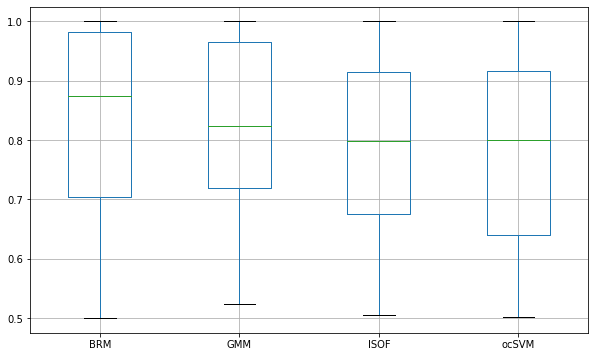

In [ ]:
dfAUC.boxplot(column = ["BRM", "GMM", "ISOF", "ocSVM"]
              ,figsize=(10,6))

print('Average AUC for Normal \n{}'.format(dfAUC[["BRM", "GMM", "ISOF", "ocSVM"]].mean()))
print()
print('Friedman Chisquare test of all normal models\n{}'.format(stats.friedmanchisquare(dfAUC.BRM.values, dfAUC.GMM.values, dfAUC.ISOF.values, dfAUC.ocSVM.values)))
print()
plt.savefig("Boxplot_Normal")

In [ ]:
sp.posthoc_nemenyi_friedman(data_normal)

,BRM,GMM,ISOF,ocSVM
BRM,1.000000,0.047928,0.001000,0.001000
GMM,0.047928,1.000000,0.110674,0.047928
ISOF,0.001000,0.110674,1.000000,0.900000
ocSVM,0.001000,0.047928,0.900000,1.000000


CD is:  0.4812237841398685


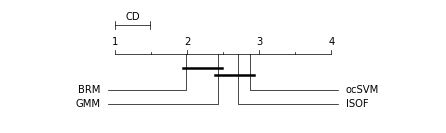

In [ ]:
names = ["BRM", "GMM", "ISOF", "ocSVM"]
average_Rank = avrRank(dfAUC[names])
num_datasets = 95

cd = Orange.evaluation.compute_CD(average_Rank, num_datasets)
Orange.evaluation.graph_ranks(average_Rank, names, cd=cd, width=6, textspace=1.5)
print('CD is: ',cd)
plt.savefig("CD_Normal")
plt.show()

Average AUC for MinMax 
BRM_MinMax      0.840542
GMM_MinMax      0.815635
ISOF_MinMax     0.788233
ocSVM_MinMax    0.784214
dtype: float64

Friedman Chisquare test of all normal models
FriedmanchisquareResult(statistic=31.98692810457516, pvalue=5.266769768474206e-07)



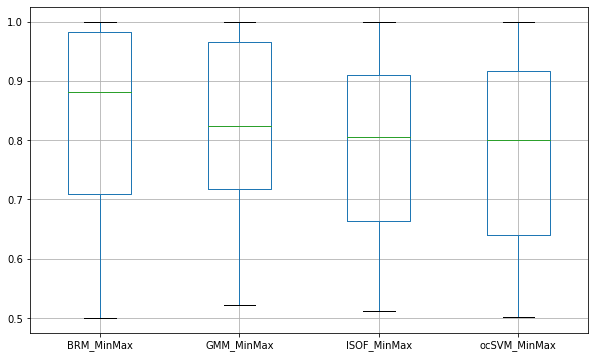

In [ ]:
dfAUC.boxplot(column = ["BRM_MinMax", "GMM_MinMax", "ISOF_MinMax", "ocSVM_MinMax"]
              ,figsize=(10,6))

print('Average AUC for MinMax \n{}'.format(dfAUC[["BRM_MinMax", "GMM_MinMax", "ISOF_MinMax", "ocSVM_MinMax"]].mean()))
print()
print('Friedman Chisquare test of all normal models\n{}'.format(stats.friedmanchisquare(dfAUC.BRM_MinMax.values, dfAUC.GMM_MinMax.values, dfAUC.ISOF_MinMax.values, dfAUC.ocSVM_MinMax.values)))
print()
plt.savefig("Boxplot_MinMax")

In [ ]:
sp.posthoc_nemenyi_friedman(data_MinMax)

,BRM_MinMax,GMM_MinMax,ISOF_MinMax,ocSVM_MinMax
BRM_MinMax,1.000000,0.012881,0.001000,0.001000
GMM_MinMax,0.012881,1.000000,0.496354,0.159989
ISOF_MinMax,0.001000,0.496354,1.000000,0.900000
ocSVM_MinMax,0.001000,0.159989,0.900000,1.000000


CD is:  0.4812237841398685


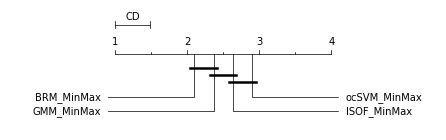

In [ ]:
names1 = ["BRM_MinMax", "GMM_MinMax", "ISOF_MinMax", "ocSVM_MinMax"]
average_Rank1 = avrRank(dfAUC[names1])
num_datasets1 = 95

cd1 = Orange.evaluation.compute_CD(average_Rank1, num_datasets1)
Orange.evaluation.graph_ranks(average_Rank1, names1, cd=cd1, width=6, textspace=1.5)
print('CD is: ',cd1)
plt.savefig("CD_MinMax")
plt.show()

Average AUC for Std 
BRM_std      0.837126
GMM_std      0.815635
ISOF_std     0.787914
ocSVM_std    0.784214
dtype: float64

Friedman Chisquare test of all normal models
FriedmanchisquareResult(statistic=35.840563991323165, pvalue=8.092721649159177e-08)



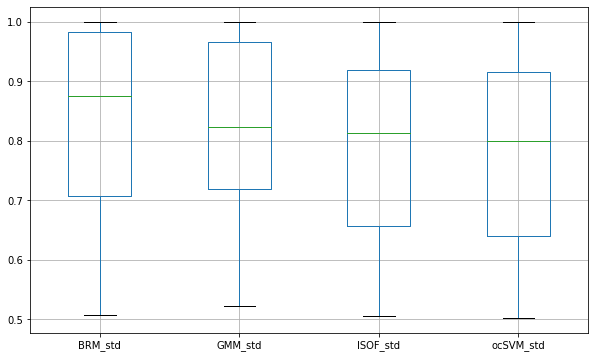

In [ ]:
dfAUC.boxplot(column = ["BRM_std", "GMM_std", "ISOF_std", "ocSVM_std"]
              ,figsize=(10,6))

print('Average AUC for Std \n{}'.format(dfAUC[["BRM_std", "GMM_std", "ISOF_std", "ocSVM_std"]].mean()))
print()
print('Friedman Chisquare test of all normal models\n{}'.format(stats.friedmanchisquare(dfAUC.BRM_std.values, dfAUC.GMM_std.values, dfAUC.ISOF_std.values, dfAUC.ocSVM_std.values)))
print()
plt.savefig("Boxplot_Std")

In [ ]:
sp.posthoc_nemenyi_friedman(data_std)

,BRM_std,GMM_std,ISOF_std,ocSVM_std
BRM_std,1.000000,0.019892,0.001000,0.001000
GMM_std,0.019892,1.000000,0.189816,0.085037
ISOF_std,0.001000,0.189816,1.000000,0.900000
ocSVM_std,0.001000,0.085037,0.900000,1.000000


CD is:  0.4812237841398685


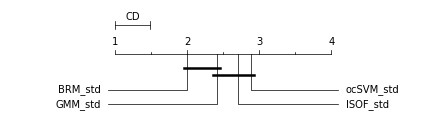

In [ ]:
names2 = ["BRM_std", "GMM_std", "ISOF_std", "ocSVM_std"]
average_Rank2 = avrRank(dfAUC[names2])
num_datasets2 = 95

cd2 = Orange.evaluation.compute_CD(average_Rank2, num_datasets2)
Orange.evaluation.graph_ranks(average_Rank2, names2, cd=cd2, width=6, textspace=1.5)
print('CD is: ',cd2)
plt.savefig("CD_Std")
plt.show()

Average AUC for Minmax_std 
BRM_Minmax_std      0.837339
GMM_Minmax_std      0.815635
ISOF_Minmax_std     0.790512
ocSVM_Minmax_std    0.784214
dtype: float64

Friedman Chisquare test of all normal models
FriedmanchisquareResult(statistic=30.858531317494588, pvalue=9.103922007040912e-07)



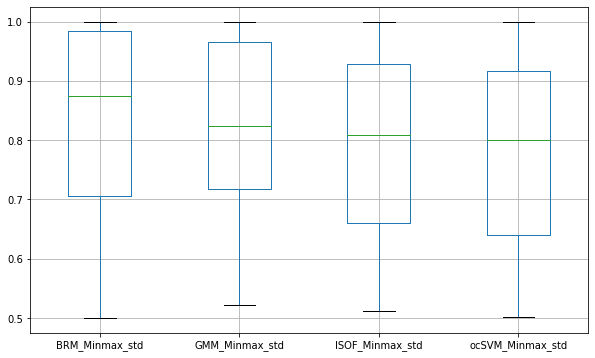

In [ ]:
dfAUC.boxplot(column = ["BRM_Minmax_std", "GMM_Minmax_std", "ISOF_Minmax_std", "ocSVM_Minmax_std"]
              ,figsize=(10,6))

print('Average AUC for Minmax_std \n{}'.format(dfAUC[["BRM_Minmax_std", "GMM_Minmax_std", "ISOF_Minmax_std", "ocSVM_Minmax_std"]].mean()))
print()
print('Friedman Chisquare test of all normal models\n{}'.format(stats.friedmanchisquare(dfAUC.BRM_Minmax_std.values, dfAUC.GMM_Minmax_std.values, dfAUC.ISOF_Minmax_std.values, dfAUC.ocSVM_Minmax_std.values)))
print()
plt.savefig("Boxplot_MM_Std")

In [ ]:
sp.posthoc_nemenyi_friedman(data_MinMax_Std)

,BRM_Minmax_std,GMM_Minmax_std,ISOF_Minmax_std,ocSVM_Minmax_std
BRM_Minmax_std,1.000000,0.027726,0.001000,0.001000
GMM_Minmax_std,0.027726,1.000000,0.591216,0.069080
ISOF_Minmax_std,0.001000,0.591216,1.000000,0.606987
ocSVM_Minmax_std,0.001000,0.069080,0.606987,1.000000


CD is:  0.4812237841398685


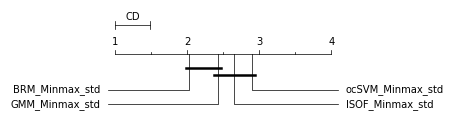

In [ ]:
names3 = ["BRM_Minmax_std", "GMM_Minmax_std", "ISOF_Minmax_std", "ocSVM_Minmax_std"]
average_Rank3 = avrRank(dfAUC[names3])
num_datasets3 = 95

cd3 = Orange.evaluation.compute_CD(average_Rank3, num_datasets3)
Orange.evaluation.graph_ranks(average_Rank3, names3, cd=cd3, width=6, textspace=1.5)
print('CD is: ',cd3)
plt.savefig("CD_MM_Std")
plt.show()

### Comparisson between BRM model variation 

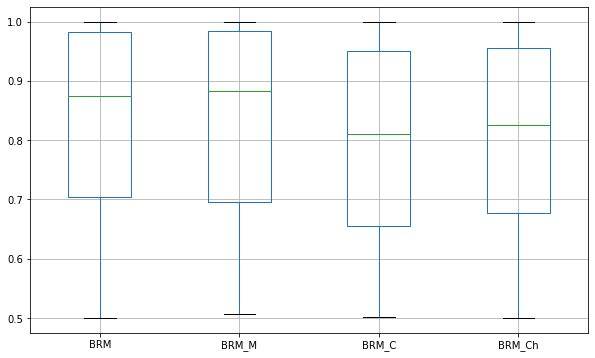

In [ ]:
dfAUC.boxplot(column = ["BRM", "BRM_M", "BRM_C", "BRM_Ch"]
              ,figsize=(10,6))
plt.savefig("BRM_Normal")

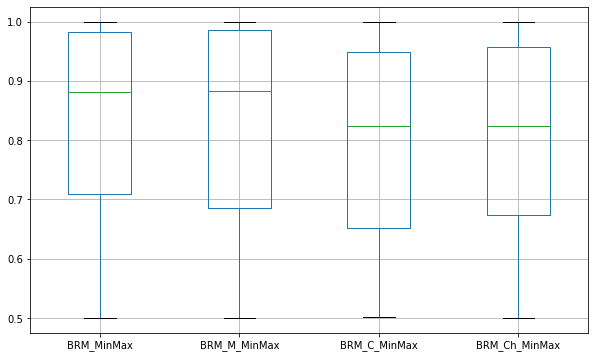

In [ ]:
dfAUC.boxplot(column = ["BRM_MinMax", "BRM_M_MinMax", "BRM_C_MinMax", "BRM_Ch_MinMax"]
              ,figsize=(10,6))
plt.savefig("BRM_MinMax")

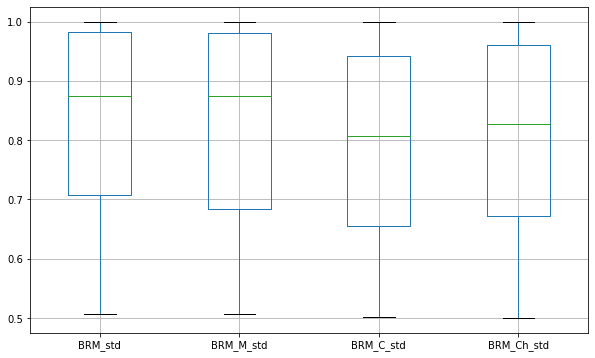

In [ ]:
dfAUC.boxplot(column = ["BRM_std", "BRM_M_std", "BRM_C_std", "BRM_Ch_std"]
              ,figsize=(10,6))
plt.savefig("BRM_Std")

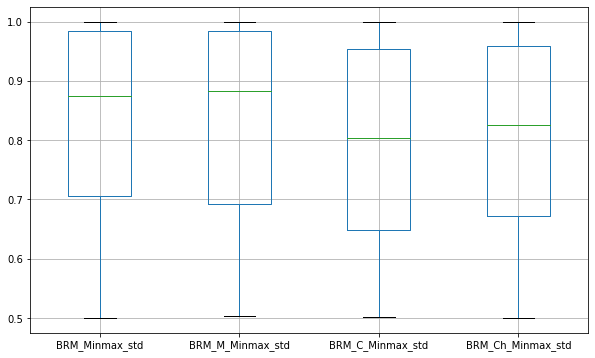

In [ ]:
dfAUC.boxplot(column = ["BRM_Minmax_std", "BRM_M_Minmax_std", "BRM_C_Minmax_std", "BRM_Ch_Minmax_std"]
              ,figsize=(10,6))
plt.savefig("BRM_MM_Std")